In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [3]:
device = torch.device("xpu")

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.fc(x)
        h = F.relu(h)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma


class Decoder(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_dim: int):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        y = self.fc1(x)
        y = F.relu(y)
        y = self.fc2(y)
        y = torch.sigmoid(y)
        return y


class VAE(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, latent_dim: int):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, sigma):
        eps = torch.randn_like(sigma)
        return mu + eps * sigma

    def forward(self, x):
        mu, sigma = self.encoder(x)
        z = self.reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction="sum")
        L2 = torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2)
        return (L1 - L2) / batch_size

In [5]:
vae = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Lambda(torch.flatten)]
)
dataset = datasets.MNIST("./data", train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

losses = []

print(summary(vae, (input_dim,)))
print(f"Dataset: {len(dataset)}, Shape: {dataset[0][0].shape}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         157,000
            Linear-2                   [-1, 20]           4,020
            Linear-3                   [-1, 20]           4,020
           Encoder-4       [[-1, 20], [-1, 20]]               0
            Linear-5                  [-1, 200]           4,200
            Linear-6                  [-1, 784]         157,584
           Decoder-7                  [-1, 784]               0
Total params: 326,824
Trainable params: 326,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.25
Estimated Total Size (MB): 1.26
----------------------------------------------------------------
None
Dataset: 60000, Shape: torch.Size([784])


In [6]:
vae.to(device)
for epoch in range(epochs):
    loss_sum = 0
    cnt = 0

    for x, label in dataloader:
        vae.zero_grad()
        loss = vae.forward(x.to(device))
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss_avg:.4f}")

Epoch 1/30, Loss: 54.4050
Epoch 2/30, Loss: 45.1812
Epoch 3/30, Loss: 43.1275
Epoch 4/30, Loss: 42.0073
Epoch 5/30, Loss: 41.3387
Epoch 6/30, Loss: 40.8877
Epoch 7/30, Loss: 40.5344
Epoch 8/30, Loss: 40.2777
Epoch 9/30, Loss: 40.0433
Epoch 10/30, Loss: 39.9022
Epoch 11/30, Loss: 39.7647
Epoch 12/30, Loss: 39.6241
Epoch 13/30, Loss: 39.5065
Epoch 14/30, Loss: 39.4271
Epoch 15/30, Loss: 39.3535
Epoch 16/30, Loss: 39.2422
Epoch 17/30, Loss: 39.1621
Epoch 18/30, Loss: 39.0960
Epoch 19/30, Loss: 39.0351
Epoch 20/30, Loss: 38.9438
Epoch 21/30, Loss: 38.8773
Epoch 22/30, Loss: 38.8655
Epoch 23/30, Loss: 38.7924
Epoch 24/30, Loss: 38.7479
Epoch 25/30, Loss: 38.6962
Epoch 26/30, Loss: 38.6261
Epoch 27/30, Loss: 38.6125
Epoch 28/30, Loss: 38.5696
Epoch 29/30, Loss: 38.5424
Epoch 30/30, Loss: 38.5305


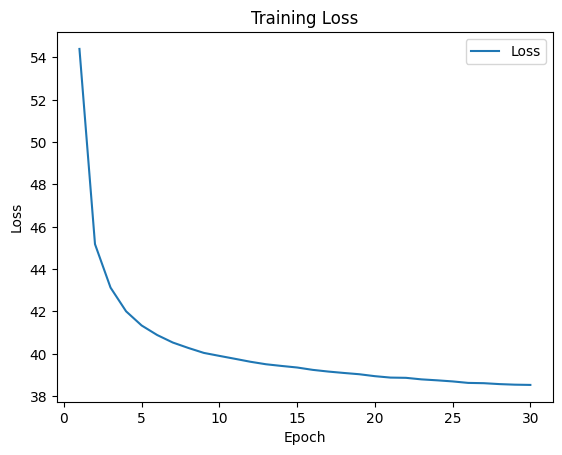

In [7]:
plot_x = range(1, epochs + 1)
plt.plot(plot_x, losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.show()

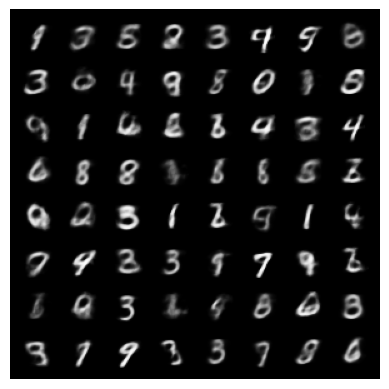

In [8]:
with torch.no_grad():
    sample_size = 64
    z = torch.randn(sample_size, latent_dim).to(device)
    x = vae.decoder(z)
    generated_images = x.view(sample_size, 1, 28, 28).cpu()

grid_img = torchvision.utils.make_grid(
    generated_images, nrow=8, padding=8, normalize=True
)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.show()

In [11]:
from safetensors.torch import save_file

save_file(vae.state_dict(), "models/vae.safetensors", metadata={"format": "torch"})
print("Model weights saved to models/vae.safetensors")

Model weights saved to models/vae.safetensors
